In [1]:
from steam import Steam
from decouple import config
import requests
import json
from pathlib import Path
from pymongo import MongoClient
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from multiprocessing import Process
import multiprocessing 
from pymongo import UpdateOne
from pymongo import InsertOne
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import clear_output
from pymongo import MongoClient
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import re
import time
from datetime import datetime
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import warnings
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from sklearn import metrics
from scipy.stats import norm
from sklearn.metrics import pairwise_distances

In [2]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['DM_Project']
collection = db['Games_updated']
df = pd.DataFrame(list(collection.find()))

## Normal Distribution of the total votes

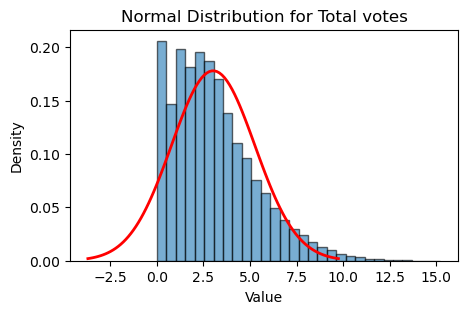

In [3]:
log_plot_df = df.copy()
log_plot_df['Log_tot'] = np.log(log_plot_df['Positive'] +log_plot_df['Negative'])
mean = log_plot_df['Log_tot'].mean()
std = log_plot_df['Log_tot'].std()
range_values = np.linspace(mean - 3*std, mean + 3*std, 100)
normal_distr_curve = norm.pdf(range_values, mean, std)
plt.figure(figsize=(5, 3))
plt.hist(log_plot_df['Log_tot'] , bins=30, density=True, alpha=0.6,edgecolor='black')
plt.plot(range_values, normal_distr_curve, 'r-', lw=2)
plt.title('Normal Distribution for Total votes')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Outlier Detection

## Highest positive vote count game (Counter-strike 2) 

_id                                    65cb6ab5dc4bd7a0c995dddd
AppID                                                       730
Name                                           Counter-Strike 2
Genres                                      [Экшены, Бесплатно]
Categories    [Для нескольких игроков, Кроссплатформенная иг...
Positive                                                3519727
Negative                                                 524152
Peak CCU                                                 825215
Name: 38425, dtype: object


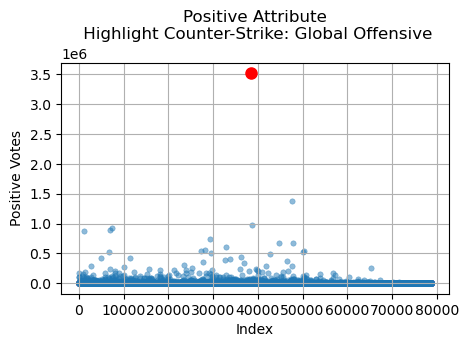

In [4]:
id_max_neg = df['Negative'].idxmax()
id_max_pos = df['Positive'].idxmax()
print(df.loc[id_max_pos])
plt.figure(figsize=(5, 3))
plt.scatter(df['Positive'].index,df['Positive'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_pos, df.loc[id_max_pos, 'Positive'], marker='o', markersize=8, color='red',alpha = 1)  
plt.title('Positive Attribute\n Highlight Counter-Strike: Global Offensive')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

## Highest negative vote count game (PUBG: BATTLEGROUNDS)

_id                                    65cb6a9ddc4bd7a0c99564bf
AppID                                                    578080
Name                                        PUBG: BATTLEGROUNDS
Genres        [Action, Adventure, Massively Multiplayer, Fre...
Categories    [Multi-player, PvP, Online PvP, Stats, Remote ...
Positive                                                 929599
Negative                                                 759795
Peak CCU                                                 275374
Name: 7419, dtype: object


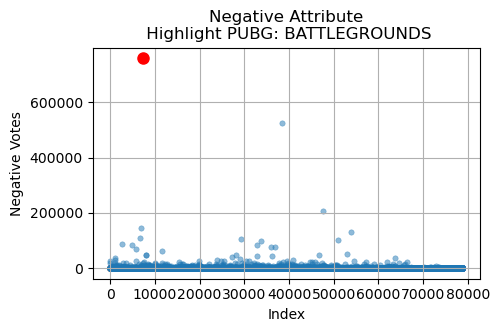

In [5]:
print(df.loc[id_max_neg])
plt.figure(figsize=(5, 3))
plt.scatter(df['Negative'].index,df['Negative'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_neg, df.loc[id_max_neg, 'Negative'], marker='o', markersize=8, color='red')  
plt.title('Negative Attribute\n Highlight PUBG: BATTLEGROUNDS')
plt.xlabel('Index')
plt.ylabel('Negative Votes')
plt.grid(True)
plt.show()

### Negative value plot for highest positive game (Counter-Strike: Global Offensive)

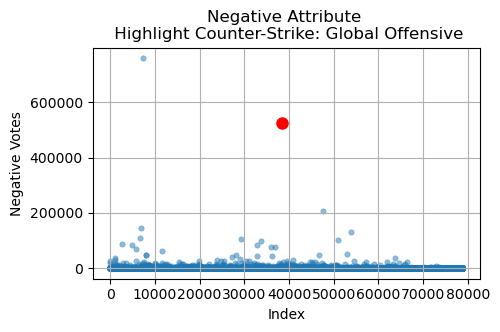

In [6]:
plt.figure(figsize=(5, 3))
plt.scatter(df['Negative'].index,df['Negative'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_pos, df.loc[id_max_pos, 'Negative'], marker='o', markersize=8, color='red')  
plt.title('Negative Attribute \n Highlight Counter-Strike: Global Offensive')
plt.xlabel('Index')
plt.ylabel('Negative Votes')
plt.grid(True)
plt.show()

# Winsorization results

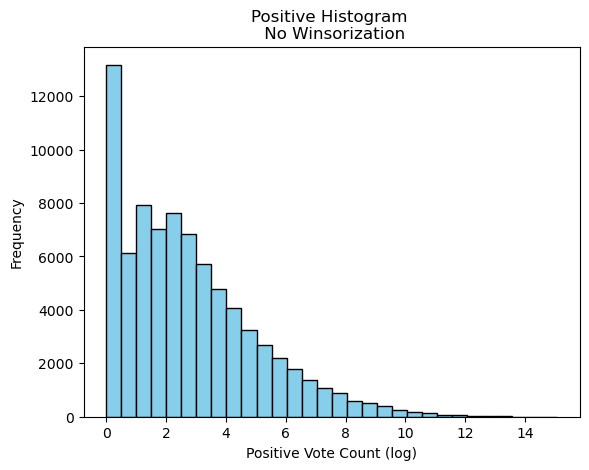

In [7]:
#Positive histogram no winsorization
test_df=df.copy()
# Add 1 to 0 values
test_df['Log_Positive'] = np.where(test_df['Positive'] == 0, test_df['Positive'] + 1, test_df['Positive'])
#Apply log
test_df['Log_Positive'] = np.log(test_df['Log_Positive'])
plt.hist(test_df['Log_Positive'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Positive Vote Count (log)')
plt.ylabel('Frequency')
plt.title('Positive Histogram \n No Winsorization')
plt.show()

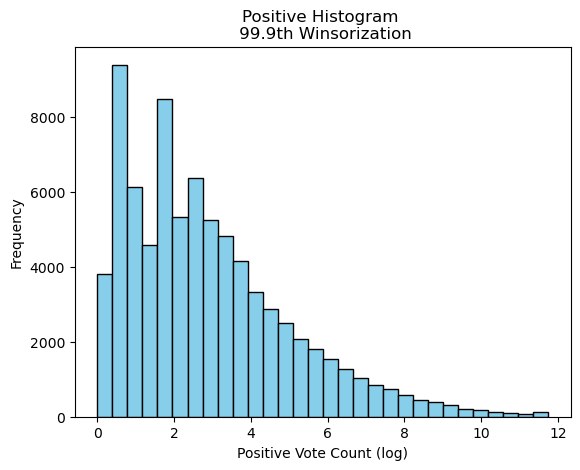

In [8]:
#Winsorize at 99.9th percentile right side only
test_df['Winsorized Positive'] = winsorize(test_df['Positive'], limits=[0, 0.001])
# Add 1 to 0 values
test_df['Log_WinPositive'] = np.where(test_df['Winsorized Positive'] == 0, test_df['Winsorized Positive'] + 1, test_df['Winsorized Positive'])
#Apply log
test_df['Log_WinPositive'] = np.log(test_df['Log_WinPositive'])
test_df['Log_WinPositive'] = np.log(test_df['Winsorized Positive'] + 1)
plt.hist(test_df['Log_WinPositive'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Positive Vote Count (log)')
plt.ylabel('Frequency')
plt.title('Positive Histogram \n 99.9th Winsorization')
plt.show()

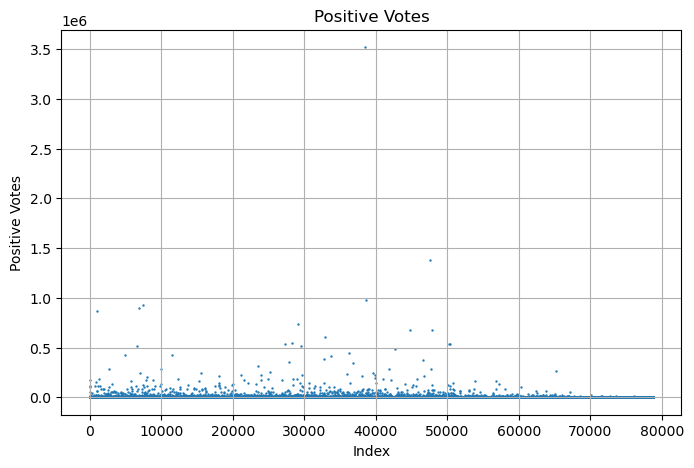

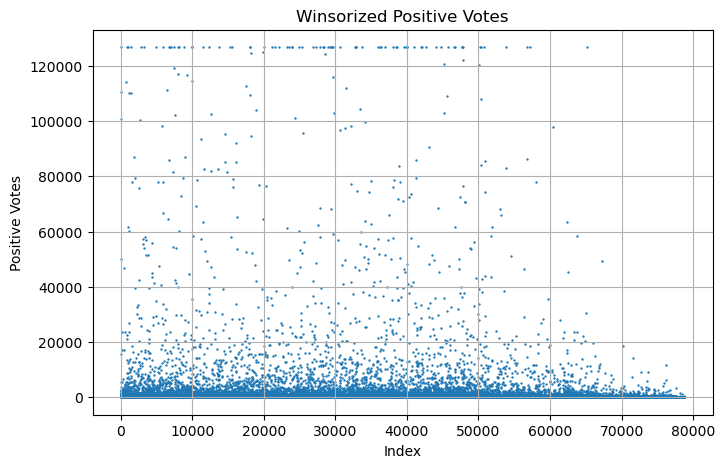

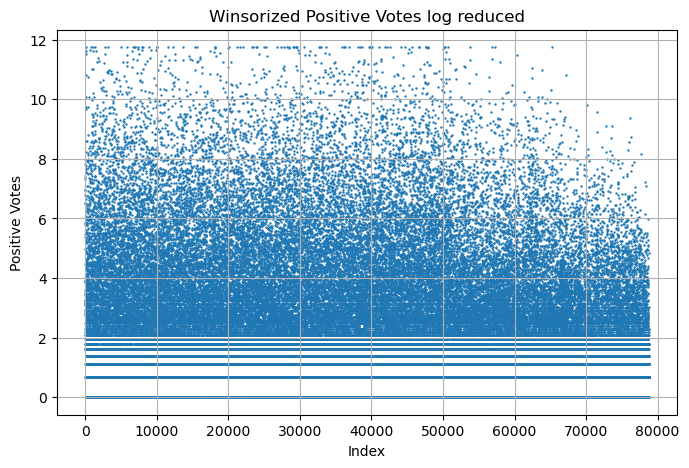

In [9]:
#Plotting entries by Positive attribute
plt.figure(figsize=(8, 5))
plt.scatter(test_df['Positive'].index,test_df['Positive'], marker='o',s = 0.5) 
plt.title('Positive Votes')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()
#Plotting entries by Winsorized Positive attribute
plt.figure(figsize=(8, 5))
plt.scatter(test_df['Winsorized Positive'].index,test_df['Winsorized Positive'], marker='o',s=0.5) 
plt.title('Winsorized Positive Votes')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()
#Plotting entries by Log Reduced Winsorized Positive attribute
plt.figure(figsize=(8, 5))
plt.scatter(test_df['Log_WinPositive'].index,test_df['Log_WinPositive'], marker='o',s=0.5) 
plt.title('Winsorized Positive Votes log reduced')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

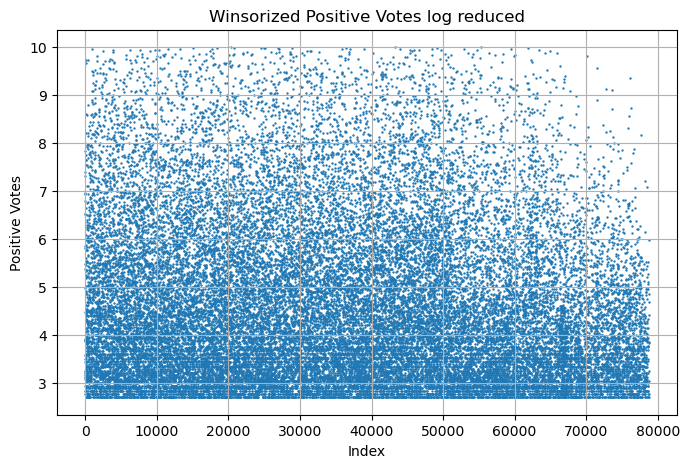

In [61]:
#Filter the attribute to visualize without constant values
filtered_df = test_df.iloc[np.where(test_df['Log_WinPositive'] > 2.7)].copy()
filtered_df = filtered_df.iloc[np.where(filtered_df['Log_WinPositive']< 10)]
#Plotting entries by Log Reduced Winsorized Positive attribute
plt.figure(figsize=(8, 5))
plt.scatter(filtered_df['Log_WinPositive'] .index,filtered_df['Log_WinPositive'] , marker='o',s=0.5) 
plt.title('Winsorized Positive Votes log reduced')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

In [62]:
filtered_df['Log_WinPositive'].value_counts()

Log_WinPositive
2.708050    1026
2.772589     935
2.833213     898
2.890372     782
2.944439     743
            ... 
8.362409       1
8.886409       1
8.771060       1
8.669227       1
7.095064       1
Name: count, Length: 3865, dtype: int64

In [58]:
len(filtered_df)

37600